In [1]:
#Loading modules

import tensorflow as tf

import pandas as pd

from matplotlib import pyplot as plt

import numpy as np

from sklearn import metrics
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

import model_stats

In [2]:
# Lets load the data, i have preprocessed it, pslit it randomly and exported it in another notebook
#To make it easier to manipulate here

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
val = pd.read_csv('val.csv')

In [3]:
#Lets drop the unnecessary columns and select our X and y data
train_X = train.drop(['Unnamed: 0', 'ids', 'tox_bin'], axis = 1)
train_y = train['tox_bin']

In [4]:
#Similarly for the val data
val_X = val.drop(['Unnamed: 0', 'ids', 'tox_bin'], axis = 1)
val_y = val['tox_bin']

In [5]:
#And the test data, I have kept the ids column in the test data so we can have a look at the most toxic molecules
test_X = test.drop(['Unnamed: 0', 'tox_bin'], axis = 1)
test_y = test['tox_bin']

In [6]:
small_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(32, activation = 'relu', input_shape = (train_X.shape[1],)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ]
)

small_model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [7]:
medium_model = tf.keras.models.load_model('tf_model.h5')

In [8]:
large_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(1500, activation = 'relu', input_shape = (train_X.shape[1],)),
        tf.keras.layers.Dropout(0.7),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(750, activation = 'relu'),
        tf.keras.layers.Dropout(0.7),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(250, activation = 'relu'),
        tf.keras.layers.Dropout(0.7),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ]
)

large_model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
models = [small_model, medium_model, large_model]

for model in models:
    model.fit(train_X, train_y, epochs = 500, batch_size = 128, validation_data = (val_X, val_y))

Epoch 1/500
62/62 [==============================] - 1s 13ms/step - loss: 0.6642 - accuracy: 0.6038 - val_loss: 0.6435 - val_accuracy: 0.6849
Epoch 2/500
62/62 [==============================] - 1s 11ms/step - loss: 0.6613 - accuracy: 0.6092 - val_loss: 0.6437 - val_accuracy: 0.6760
Epoch 3/500
62/62 [==============================] - 1s 10ms/step - loss: 0.6577 - accuracy: 0.6149 - val_loss: 0.6420 - val_accuracy: 0.6798
Epoch 4/500
62/62 [==============================] - 1s 10ms/step - loss: 0.6582 - accuracy: 0.6112 - val_loss: 0.6394 - val_accuracy: 0.6824
Epoch 5/500
62/62 [==============================] - 1s 10ms/step - loss: 0.6573 - accuracy: 0.6130 - val_loss: 0.6387 - val_accuracy: 0.6837
Epoch 6/500
62/62 [==============================] - 1s 10ms/step - loss: 0.6572 - accuracy: 0.6191 - val_loss: 0.6361 - val_accuracy: 0.6862
Epoch 7/500
62/62 [==============================] - 1s 10ms/step - loss: 0.6539 - accuracy: 0.6259 - val_loss: 0.6367 - val_accuracy: 0.6837
Epoch 

In [12]:
for model in models:
    print(model.count_params())

3357
190801
1457251


In [30]:
from sklearn.metrics import fbeta_score
import model_stats


model_stats_dict = {}

for model in models:
    ms = model_stats.stats(model, test_X.drop('ids', axis = 1), test_y)
    ms.get_threshold_scores()
    model_stats_dict[model] = ms
    

25/25 [==============================] - 0s 3ms/step


(0.0, 1.0)

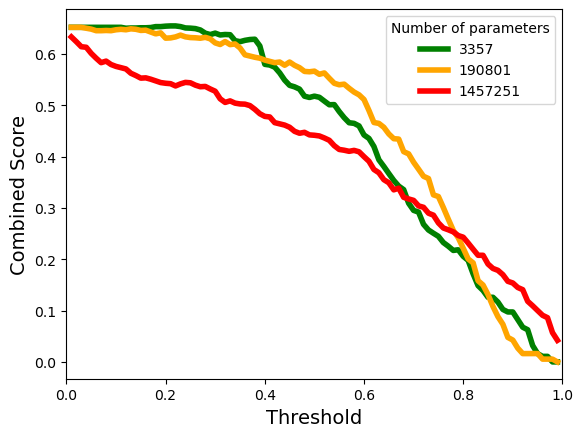

In [45]:
colors = ['green', 'orange', 'red']

for i, (k, v) in enumerate(model_stats_dict.items()):
    combined = v.threshold_scores_df['combined']
    combined.plot(label = k.count_params(), color=colors[i], linewidth = 4)

plt.legend(title='Number of parameters')   
plt.xlabel('Threshold', fontsize = 14)
plt.ylabel('Combined Score', fontsize = 14) 
plt.xlim(0, 1)


In [47]:
y_pred = small_model.predict(test_X.drop('ids', axis = 1))


prediction = pd.concat([test_X['ids'], test_y, pd.DataFrame(y_pred)], axis = 1)

25/25 [==============================] - 0s 4ms/step


In [50]:
prediction = prediction.rename(columns = {0: 'prediction'})
prediction

,ids,tox_bin,prediction
0,O=S(=O)([O-])c1cc(O)ccc1O,0,0.547206
1,Cc1cn([C@H]2C=C[C@@H](CO)O2)c(=O)[nH]c1=O,0,0.246894
2,CCCCc1nc2cccnc2n1Cc1ccc(-c2ccccc2-c2nnn[n-]2)cc1,1,0.698589
3,CCN(CC)CCOC(=O)C1(c2ccccc2)CCCC1.CCN(CC)CCOC(=...,0,0.424995
4,CC(=O)SC[C@@H](C)C(=O)N1CCC[C@H]1C(=O)N[C@@H](...,0,0.304463
...,...,...,...
778,C1CSCCS1,0,0.591752
779,CC(=O)CC(C)(C)O,0,0.305277
780,CC(C)=CCNc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](...,1,0.343047
781,COc1ccc(CN2CCN(C(c3ccc(F)cc3)c3ccc(F)cc3)CC2)c...,1,0.510794


In [51]:
sorted_df = prediction.sort_values(by = 'prediction', ascending = False)

sorted_df

,ids,tox_bin,prediction
700,CC(C(O)c1ccccc1)N(C)CCOC(c1ccccc1)c1ccccc1,0,0.976399
398,IC(I)I,1,0.972524
333,Cc1cc(O)c2c(c1)C(=O)c1cc(O)cc(O)c1C2=O,1,0.971642
42,Nc1c(Cl)cc(Cl)cc1Cl,0,0.971518
429,C1CC2OC2CC1C1CO1,0,0.969301
...,...,...,...
441,C#CC(C)(C)O,0,0.170571
326,COc1nc(C)nc(NC(=O)NS(=O)(=O)c2ccccc2OCCCl)n1,0,0.160016
575,CCN[C@@H]1C[C@H](N)[C@@H](OC2OC(CN)=CCC2N)[C@H...,0,0.145643
365,CCc1c(C)[nH]c2c1C(=O)C(CN1CCOCC1)CC2,0,0.129314


In [53]:
prediction.to_csv('prediction.csv')